<a href="https://colab.research.google.com/github/Pratyushanand26/WiDS_5.0/blob/main/Micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [104]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [105]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class Value:
  def __init__(self,data,_children=(),_op='',label=''):
    self.data=data
    self._prev=set(_children)
    self._op=_op
    self.label=label
    self.grad=0.0
    self._backward=lambda:None

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self,other):
    other=other if isinstance(other,Value) else Value(other)
    out=Value(self.data+other.data,(self,other),'+')
    def _backward():
      self.grad += 1.0*out.grad # Corrected to accumulate
      other.grad += 1.0*out.grad # Corrected to accumulate
    out._backward=_backward

    return out

  def __radd__(self, other):
    return self + other


  def __mul__(self,other):
    other=other if isinstance(other,Value) else Value(other)
    out=Value(self.data*other.data,(self,other),'*')
    def _backward():
      self.grad += other.data*out.grad
      other.grad += self.data*out.grad
    out._backward=_backward

    return out

  def __rmul__(self,other):
    return self*other

  def __neg__(self):
    return self * -1

  def __sub__(self,other):
    return self + (-other)

  def __pow__(self,other):
    assert isinstance(other,(int,float))
    out=Value(self.data**other,(self,),f'**{other}')

    def _backward():
      self.grad+=other*(self.data**(other-1))*out.grad
    out._backward=_backward

    return out


  def __truediv__(self,other):
    return self*(other**-1)

  def exp(self):
    data=self.data
    out=Value(math.exp(data),(self, ),'exp')

    def _backward():
      self.grad+=out.data*out.grad
    out._backward=_backward

    return out

  def tanh(self):
    data=self.data
    t=(math.exp(2*data)-1)/(math.exp(2*data)+1)
    out=Value(t,(self, ),'tanh')
    def _backward():
      self.grad += (1-t**2)*out.grad # Corrected to accumulate
    out._backward=_backward

    return out

  def backward(self):

    #copied(but understood)
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


In [106]:
a=Value(4)
b=Value(3)
c=Value(2)
a/b

Value(data=1.3333333333333333)

In [107]:
#Copied from lecture

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [108]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

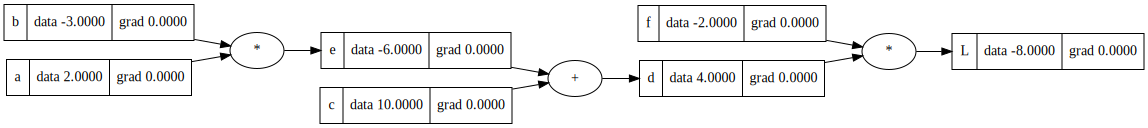

In [109]:
draw_dot(L)

In [110]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

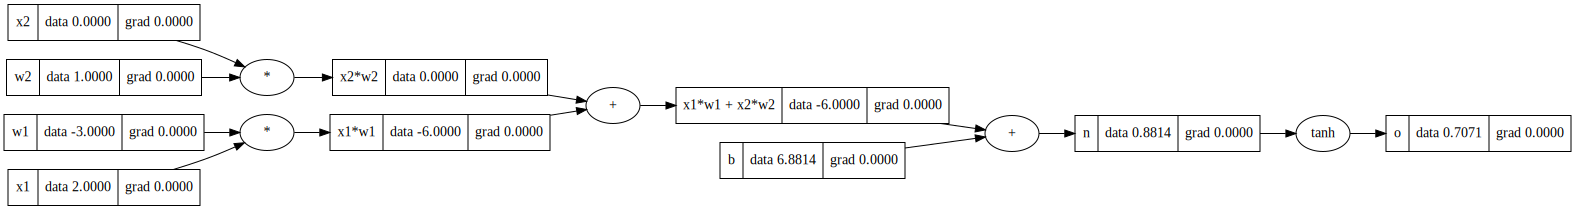

In [111]:
draw_dot(o)

In [112]:
o.backward()
x2.grad

0.4999999999999999

In [113]:
#Perceptron implementation

class Neuron:
  def __init__(self,nin):
    self.w=[Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b=Value(random.uniform(-1,1))

  def __call__(self,x):
    act=sum((xi*wi for xi,wi in zip(self.w,x)),self.b)
    out=act.tanh()
    return out

  def parameters(self):
    return self.w+[self.b]

class Layer:
  def __init__(self,nin,nout):
    self.neurons=[Neuron(nin) for _ in range(nout)]

  def __call__(self,x):
    outs=[n(x) for n in self.neurons]
    return outs[0] if len(outs)==1 else outs

  def parameters(self):
    params=[];
    for neuron in self.neurons:
      params.extend(neuron.parameters())
    return params

class MLP:
  def __init__(self,nin,nouts):
    sz=[nin]+nouts
    self.layers=[Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

  def __call__(self,x):
    for layer in self.layers:
      x=layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [114]:
x=[1.0,2.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.7168235205019884)

In [115]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [116]:
for i in range(100):
  ypred = [n(x) for x in xs]
  loss=sum((yout-ygt)**2 for ygt,yout in zip(ys,ypred))

  for p in n.parameters():
    p.grad=0.0
  loss.backward()

  for p in n.parameters():
    p.data+=-0.05*p.grad
  print(i,loss.data)

0 6.2267515427585405
1 3.0590849914486524
2 2.2460296949324237
3 1.7107498245065549
4 1.671144860720392
5 1.7994747253433465
6 0.6425424625266672
7 0.17456114773809855
8 0.13994959537132862
9 0.12094637873800437
10 0.10700211131314566
11 0.09592482176884826
12 0.08683209515869092
13 0.07922128534349832
14 0.07275862045832629
15 0.06720642429318738
16 0.06238885675216785
17 0.058172487604307266
18 0.05445410191128883
19 0.051152587112796334
20 0.048203331238417996
21 0.04555425027212951
22 0.043162911069358496
23 0.040994410872062285
24 0.03901979057176752
25 0.03721483130908659
26 0.03555913070543364
27 0.034035385922480635
28 0.03262883162380442
29 0.031326795278374855
30 0.030118342287487082
31 0.02899399053723327
32 0.027945479093272607
33 0.026965579472350162
34 0.026047940657018303
35 0.025186961048170545
36 0.024377682069957142
37 0.023615699290889827
38 0.022897087801128105
39 0.022218339259185253
40 0.021576308542429888
41 0.020968168341971464
42 0.02039137036123587
43 0.019843

In [117]:
ypred

[Value(data=0.9602823437340876),
 Value(data=-0.9710396072167703),
 Value(data=-0.9497121107796889),
 Value(data=0.9483589202520314)]